#### Library

In [1]:
import importlib
import Training_utils
import torchvision
from torchvision import transforms
import tb_utils
importlib.reload(tb_utils)
from tb_utils import *
importlib.reload(Training_utils)
from Training_utils import *
from Image_Process_utils import *
import model_utils
importlib.reload(model_utils)
from model_utils import *
from Dataset_utils import *
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
if not os.path.exists('./Acu_Dataset'):
    os.mkdir('./Acu_Dataset')
import arg_parser
importlib.reload(arg_parser) 
from arg_parser import common_arg_parser

In [2]:
from torch.utils.data import ConcatDataset

In [3]:
global t_step
global v_step
global test_step
global micro_step
global v_micro
t_step = v_step = test_step = micro_step = v_micro = 0

In [4]:
arg_parser =common_arg_parser()
args, unknown_args = arg_parser.parse_known_args()

In [5]:
batch_size =12
my_transforms = transforms.Compose([
    #transforms.Normalize((0.5,), (0.5,)),
    Rescale(256),
    Tensorize()
    ])
img_dir = './Acu_Dataset/sangyang/rotated/rotated' # './Acu_Dataset/sangyang/org'
json_file = './Acu_Dataset/sangyang/rotated/sangyang_rotated.json' # './Acu_Dataset/sangyang/sangyang_info.json'
d1= HandDataSet(json_file, img_dir, transform = my_transforms, train=True) # pytorch 로 변환

set()


In [6]:
img_dir = './Acu_Dataset/sangyang/filled/filled' # './Acu_Dataset/sangyang/org'
json_file = './Acu_Dataset/sangyang/filled/sangyang_filled.json' # './Acu_Dataset/sangyang/sangyang_info.json'
d2= HandDataSet(json_file, img_dir, transform = my_transforms, train=True) # pytorch 로 변환

set()


In [7]:
img_dir = './Acu_Dataset/sangyang/org' # './Acu_Dataset/sangyang/org'
json_file = './Acu_Dataset/sangyang/sangyang_info.json' # './Acu_Dataset/sangyang/sangyang_info.json'
d3= HandDataSet(json_file, img_dir, transform = my_transforms, train=True, hand_flag=True) # pytorch 로 변환

set()


In [8]:
hugye_dataset = ConcatDataset([d1, d2, d3])

In [ ]:
with open(json_file) as f:
    json_data = json.load(f)
len(json_data)

In [9]:
test_set_size = int(len(hugye_dataset) * 0.1)
train_set_size = len(hugye_dataset) - test_set_size
train_set, test_set = torch.utils.data.random_split(hugye_dataset, [train_set_size, test_set_size])

valid_set_size = int((train_set_size)*0.1) 
train_set_size = train_set_size - valid_set_size

train_set, valid_set  = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size])

In [10]:
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size = 32, shuffle = True, num_workers=4)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = True, num_workers=4)

In [11]:
model_name = args.model
model = create_model(model_name)
summary(model.to('cuda'), input_size = (3, 700, 700))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 350, 350]           9,408
       BatchNorm2d-2         [-1, 64, 350, 350]             128
              ReLU-3         [-1, 64, 350, 350]               0
         MaxPool2d-4         [-1, 64, 175, 175]               0
            Conv2d-5         [-1, 64, 175, 175]          36,864
       BatchNorm2d-6         [-1, 64, 175, 175]             128
              ReLU-7         [-1, 64, 175, 175]               0
            Conv2d-8         [-1, 64, 175, 175]          36,864
       BatchNorm2d-9         [-1, 64, 175, 175]             128
             ReLU-10         [-1, 64, 175, 175]               0
       BasicBlock-11         [-1, 64, 175, 175]               0
           Conv2d-12         [-1, 64, 175, 175]          36,864
      BatchNorm2d-13         [-1, 64, 175, 175]             128
             ReLU-14         [-1, 64, 1

In [20]:
best_val = 100000000
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.5, 0.999))
#torch.optim.SGD(model.parameters(), args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
#momentum = 0.9 
#dataloader = train_loader
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.9)
class_loss = class_loss()
coord_loss = coord_loss()

In [21]:
today = str(datetime.datetime.now().today())
time_info = today[5:7] +today[8:10] + '_' + today[11:13] + today[14:16]
args.prefix = 'sangyang' + time_info
args.epochs = 100
writer = SummaryWriter('runs/'+args.prefix)

In [12]:
# for creating 
test_imlist, target_imlist =  gen_test_img_list()

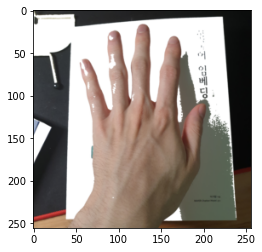

In [18]:
np_img = np.transpose( to_numpy(test_imlist[1]), (1,2,0))
plt.imshow(np_img)

In [ ]:
#step1 = 0
for epoch in range(args.start_epoch, args.epochs):
    tr_loss, micro_step, t_step =  train(model, train_loader, optimizer, coord_loss, class_loss, epoch, writer, micro_step, t_step)
    val_loss, v_micro, v_step = validate(model, valid_loader, coord_loss, class_loss, epoch, writer, v_micro, v_step)
    test_step = test(test_imlist, target_imlist, model, writer, 'test_image', test_step)
    writer.flush()
    
    val_loss
    is_best = sum(val_loss[0:2]) < best_val
    best_val = min( sum(val_loss[0:2]), best_val )
    
    save_checkpoint({
        'epoch' : epoch,
        'model' : args.model, 
        'state_dict' : model.state_dict(),
        'best_val' : best_val, 
        'optimizer' : optimizer.state_dict(),
        'scheduler' : scheduler.state_dict()
    }, is_best, args.prefix)
    
    
    
    scheduler.step()
    
    

Epoch[1] Batch 10/429  Time 0.754s Data 0.597s || LOSS: CLS 0.739 X 16232.28 Y 8703.50 tot 24936.518 | Current: 17:27:22
Epoch[1] Batch 20/429  Time 0.470s Data 0.315s || LOSS: CLS 0.721 X 15030.19 Y 7646.55 tot 22677.460 | Current: 17:27:24
Epoch[1] Batch 30/429  Time 0.368s Data 0.214s || LOSS: CLS 0.717 X 14125.35 Y 7027.36 tot 21153.422 | Current: 17:27:25
Epoch[1] Batch 40/429  Time 0.318s Data 0.163s || LOSS: CLS 0.718 X 12946.98 Y 6231.18 tot 19178.871 | Current: 17:27:27
Epoch[1] Batch 50/429  Time 0.286s Data 0.132s || LOSS: CLS 0.720 X 11972.67 Y 5495.20 tot 17468.587 | Current: 17:27:28
Epoch[1] Batch 60/429  Time 0.266s Data 0.111s || LOSS: CLS 0.720 X 11066.09 Y 4925.19 tot 15991.999 | Current: 17:27:30
Epoch[1] Batch 70/429  Time 0.252s Data 0.096s || LOSS: CLS 0.720 X 10181.01 Y 4427.69 tot 14609.416 | Current: 17:27:32
Epoch[1] Batch 80/429  Time 0.240s Data 0.085s || LOSS: CLS 0.725 X 9369.18 Y 4028.83 tot 13398.731 | Current: 17:27:33
Epoch[1] Batch 90/429  Time 0.232

Epoch[2] Batch 240/429  Time 0.195s Data 0.033s || LOSS: CLS 0.538 X 635.22 Y 394.23 tot 1029.994 | Current: 17:29:43
Epoch[2] Batch 250/429  Time 0.193s Data 0.032s || LOSS: CLS 0.534 X 625.71 Y 387.84 tot 1014.089 | Current: 17:29:44
Epoch[2] Batch 260/429  Time 0.192s Data 0.031s || LOSS: CLS 0.533 X 620.29 Y 381.21 tot 1002.027 | Current: 17:29:46
Epoch[2] Batch 270/429  Time 0.191s Data 0.030s || LOSS: CLS 0.532 X 611.47 Y 378.99 tot 990.991 | Current: 17:29:47
Epoch[2] Batch 280/429  Time 0.190s Data 0.029s || LOSS: CLS 0.531 X 605.92 Y 374.76 tot 981.212 | Current: 17:29:49
Epoch[2] Batch 290/429  Time 0.189s Data 0.028s || LOSS: CLS 0.528 X 596.70 Y 370.37 tot 967.600 | Current: 17:29:51
Epoch[2] Batch 300/429  Time 0.188s Data 0.028s || LOSS: CLS 0.526 X 591.13 Y 365.59 tot 957.244 | Current: 17:29:52
Epoch[2] Batch 310/429  Time 0.187s Data 0.027s || LOSS: CLS 0.525 X 587.94 Y 368.94 tot 957.408 | Current: 17:29:54
Epoch[2] Batch 320/429  Time 0.186s Data 0.026s || LOSS: CLS 

Epoch[4] Batch 30/429  Time 0.377s Data 0.215s || LOSS: CLS 0.370 X 125.18 Y 110.65 tot 236.193 | Current: 17:32:30
Epoch[4] Batch 40/429  Time 0.327s Data 0.163s || LOSS: CLS 0.377 X 130.97 Y 100.17 tot 231.518 | Current: 17:32:32
Epoch[4] Batch 50/429  Time 0.296s Data 0.132s || LOSS: CLS 0.377 X 130.79 Y 107.12 tot 238.292 | Current: 17:32:34
Epoch[4] Batch 60/429  Time 0.275s Data 0.111s || LOSS: CLS 0.376 X 130.28 Y 104.88 tot 235.533 | Current: 17:32:35
Epoch[4] Batch 70/429  Time 0.260s Data 0.096s || LOSS: CLS 0.380 X 132.02 Y 101.66 tot 234.061 | Current: 17:32:37
Epoch[4] Batch 80/429  Time 0.249s Data 0.085s || LOSS: CLS 0.382 X 130.30 Y 100.82 tot 231.500 | Current: 17:32:39
Epoch[4] Batch 90/429  Time 0.240s Data 0.076s || LOSS: CLS 0.383 X 127.73 Y 104.77 tot 232.877 | Current: 17:32:40
Epoch[4] Batch 100/429  Time 0.233s Data 0.069s || LOSS: CLS 0.384 X 126.34 Y 101.66 tot 228.380 | Current: 17:32:42
Epoch[4] Batch 110/429  Time 0.227s Data 0.063s || LOSS: CLS 0.384 X 12

Epoch[5] Batch 290/429  Time 0.196s Data 0.028s || LOSS: CLS 0.367 X 67.39 Y 66.10 tot 133.863 | Current: 17:35:00
Epoch[5] Batch 300/429  Time 0.195s Data 0.028s || LOSS: CLS 0.370 X 67.13 Y 65.52 tot 133.016 | Current: 17:35:01
Epoch[5] Batch 310/429  Time 0.194s Data 0.027s || LOSS: CLS 0.368 X 66.68 Y 64.87 tot 131.922 | Current: 17:35:03
Epoch[5] Batch 320/429  Time 0.194s Data 0.026s || LOSS: CLS 0.368 X 67.30 Y 65.81 tot 133.475 | Current: 17:35:05
Epoch[5] Batch 330/429  Time 0.193s Data 0.025s || LOSS: CLS 0.367 X 68.56 Y 66.57 tot 135.496 | Current: 17:35:07
Epoch[5] Batch 340/429  Time 0.193s Data 0.025s || LOSS: CLS 0.366 X 68.37 Y 66.47 tot 135.210 | Current: 17:35:08
Epoch[5] Batch 350/429  Time 0.192s Data 0.024s || LOSS: CLS 0.367 X 68.03 Y 67.15 tot 135.545 | Current: 17:35:10
Epoch[5] Batch 360/429  Time 0.192s Data 0.024s || LOSS: CLS 0.365 X 68.02 Y 66.60 tot 134.981 | Current: 17:35:12
Epoch[5] Batch 370/429  Time 0.192s Data 0.023s || LOSS: CLS 0.364 X 67.08 Y 66.

Epoch[7] Batch 100/429  Time 0.243s Data 0.073s || LOSS: CLS 0.340 X 67.85 Y 60.64 tot 128.830 | Current: 17:37:59
Epoch[7] Batch 110/429  Time 0.237s Data 0.067s || LOSS: CLS 0.337 X 66.20 Y 58.69 tot 125.220 | Current: 17:38:01
Epoch[7] Batch 120/429  Time 0.232s Data 0.062s || LOSS: CLS 0.337 X 64.37 Y 57.89 tot 122.601 | Current: 17:38:02
Epoch[7] Batch 130/429  Time 0.228s Data 0.057s || LOSS: CLS 0.341 X 63.55 Y 56.58 tot 120.474 | Current: 17:38:04
Epoch[7] Batch 140/429  Time 0.224s Data 0.054s || LOSS: CLS 0.338 X 61.26 Y 55.28 tot 116.878 | Current: 17:38:06
Epoch[7] Batch 150/429  Time 0.221s Data 0.050s || LOSS: CLS 0.337 X 60.95 Y 54.51 tot 115.795 | Current: 17:38:08
Epoch[7] Batch 160/429  Time 0.218s Data 0.048s || LOSS: CLS 0.336 X 59.58 Y 53.78 tot 113.699 | Current: 17:38:10
Epoch[7] Batch 170/429  Time 0.216s Data 0.045s || LOSS: CLS 0.336 X 59.38 Y 52.86 tot 112.573 | Current: 17:38:11
Epoch[7] Batch 180/429  Time 0.215s Data 0.043s || LOSS: CLS 0.335 X 58.77 Y 52.

Epoch[8] Batch 360/429  Time 0.194s Data 0.023s || LOSS: CLS 0.321 X 37.50 Y 36.83 tot 74.658 | Current: 17:40:31
Epoch[8] Batch 370/429  Time 0.194s Data 0.022s || LOSS: CLS 0.320 X 37.33 Y 36.67 tot 74.326 | Current: 17:40:33
Epoch[8] Batch 380/429  Time 0.193s Data 0.022s || LOSS: CLS 0.319 X 37.16 Y 36.46 tot 73.938 | Current: 17:40:35
Epoch[8] Batch 390/429  Time 0.193s Data 0.021s || LOSS: CLS 0.320 X 36.96 Y 36.36 tot 73.640 | Current: 17:40:37
Epoch[8] Batch 400/429  Time 0.193s Data 0.021s || LOSS: CLS 0.320 X 37.15 Y 36.25 tot 73.717 | Current: 17:40:38
Epoch[8] Batch 410/429  Time 0.192s Data 0.021s || LOSS: CLS 0.319 X 36.85 Y 36.26 tot 73.420 | Current: 17:40:40
Epoch[8] Batch 420/429  Time 0.192s Data 0.020s || LOSS: CLS 0.320 X 36.49 Y 36.21 tot 73.027 | Current: 17:40:42
Epoch[8] Batch 10/48  Time 1.003s || LOSS: CLS 0.328 X 14.39 Y 26.66 tot 41.378 | Current: 17:40:55
Epoch[8] Batch 20/48  Time 0.651s || LOSS: CLS 0.320 X 15.22 Y 30.27 tot 45.812 | Current: 17:40:58
Ep

Epoch[10] Batch 170/429  Time 0.216s Data 0.043s || LOSS: CLS 0.310 X 20.50 Y 19.84 tot 40.653 | Current: 17:43:33
Epoch[10] Batch 180/429  Time 0.214s Data 0.041s || LOSS: CLS 0.308 X 20.30 Y 20.33 tot 40.931 | Current: 17:43:34
Epoch[10] Batch 190/429  Time 0.212s Data 0.039s || LOSS: CLS 0.307 X 20.54 Y 20.40 tot 41.245 | Current: 17:43:36
Epoch[10] Batch 200/429  Time 0.211s Data 0.038s || LOSS: CLS 0.308 X 20.87 Y 20.42 tot 41.596 | Current: 17:43:38
Epoch[10] Batch 210/429  Time 0.210s Data 0.036s || LOSS: CLS 0.306 X 20.62 Y 20.45 tot 41.380 | Current: 17:43:40
Epoch[10] Batch 220/429  Time 0.208s Data 0.035s || LOSS: CLS 0.306 X 20.64 Y 20.60 tot 41.551 | Current: 17:43:42
Epoch[10] Batch 230/429  Time 0.207s Data 0.033s || LOSS: CLS 0.305 X 20.77 Y 21.15 tot 42.222 | Current: 17:43:43
Epoch[10] Batch 240/429  Time 0.206s Data 0.032s || LOSS: CLS 0.303 X 20.61 Y 21.28 tot 42.194 | Current: 17:43:45
Epoch[10] Batch 250/429  Time 0.205s Data 0.031s || LOSS: CLS 0.303 X 20.76 Y 21

Epoch[11] Batch 10/48  Time 0.983s || LOSS: CLS 0.266 X 18.76 Y 18.70 tot 37.724 | Current: 17:46:19
Epoch[11] Batch 20/48  Time 0.648s || LOSS: CLS 0.279 X 25.01 Y 27.67 tot 52.961 | Current: 17:46:22
Epoch[11] Batch 30/48  Time 0.556s || LOSS: CLS 0.291 X 23.91 Y 25.18 tot 49.383 | Current: 17:46:26
Epoch[11] Batch 40/48  Time 0.488s || LOSS: CLS 0.302 X 24.40 Y 26.05 tot 50.757 | Current: 17:46:29
writing test img with step 10
Epoch[12] Batch 10/429  Time 0.774s Data 0.607s || LOSS: CLS 0.270 X 22.34 Y 22.18 tot 44.793 | Current: 17:46:41
Epoch[12] Batch 20/429  Time 0.491s Data 0.320s || LOSS: CLS 0.307 X 20.40 Y 23.90 tot 44.603 | Current: 17:46:43
Epoch[12] Batch 30/429  Time 0.391s Data 0.218s || LOSS: CLS 0.292 X 22.93 Y 23.75 tot 46.973 | Current: 17:46:45
Epoch[12] Batch 40/429  Time 0.341s Data 0.166s || LOSS: CLS 0.294 X 20.55 Y 21.58 tot 42.425 | Current: 17:46:47
Epoch[12] Batch 50/429  Time 0.308s Data 0.134s || LOSS: CLS 0.293 X 20.83 Y 21.19 tot 42.321 | Current: 17:46

Epoch[13] Batch 230/429  Time 0.206s Data 0.033s || LOSS: CLS 0.265 X 15.27 Y 14.15 tot 29.687 | Current: 17:49:11
Epoch[13] Batch 240/429  Time 0.205s Data 0.031s || LOSS: CLS 0.266 X 15.29 Y 14.27 tot 29.825 | Current: 17:49:12
Epoch[13] Batch 250/429  Time 0.204s Data 0.030s || LOSS: CLS 0.266 X 15.46 Y 14.13 tot 29.858 | Current: 17:49:14
Epoch[13] Batch 260/429  Time 0.203s Data 0.029s || LOSS: CLS 0.266 X 15.49 Y 14.18 tot 29.941 | Current: 17:49:16
Epoch[13] Batch 270/429  Time 0.202s Data 0.028s || LOSS: CLS 0.266 X 15.51 Y 14.24 tot 30.014 | Current: 17:49:18
Epoch[13] Batch 280/429  Time 0.201s Data 0.028s || LOSS: CLS 0.266 X 15.62 Y 14.26 tot 30.155 | Current: 17:49:20
Epoch[13] Batch 290/429  Time 0.200s Data 0.027s || LOSS: CLS 0.266 X 15.64 Y 14.18 tot 30.091 | Current: 17:49:21
Epoch[13] Batch 300/429  Time 0.200s Data 0.026s || LOSS: CLS 0.267 X 15.50 Y 14.11 tot 29.879 | Current: 17:49:23
Epoch[13] Batch 310/429  Time 0.199s Data 0.025s || LOSS: CLS 0.267 X 15.32 Y 14

Epoch[15] Batch 30/429  Time 0.402s Data 0.227s || LOSS: CLS 0.241 X 10.19 Y 14.13 tot 24.563 | Current: 17:52:12
Epoch[15] Batch 40/429  Time 0.349s Data 0.173s || LOSS: CLS 0.239 X 10.48 Y 13.09 tot 23.809 | Current: 17:52:14
Epoch[15] Batch 50/429  Time 0.315s Data 0.140s || LOSS: CLS 0.236 X 10.14 Y 13.03 tot 23.403 | Current: 17:52:16
Epoch[15] Batch 60/429  Time 0.294s Data 0.117s || LOSS: CLS 0.242 X 9.87 Y 12.33 tot 22.447 | Current: 17:52:17
Epoch[15] Batch 70/429  Time 0.278s Data 0.102s || LOSS: CLS 0.238 X 9.48 Y 11.44 tot 21.165 | Current: 17:52:19
Epoch[15] Batch 80/429  Time 0.268s Data 0.090s || LOSS: CLS 0.242 X 9.50 Y 11.53 tot 21.266 | Current: 17:52:21
Epoch[15] Batch 90/429  Time 0.259s Data 0.080s || LOSS: CLS 0.243 X 9.21 Y 11.48 tot 20.933 | Current: 17:52:23
Epoch[15] Batch 100/429  Time 0.251s Data 0.073s || LOSS: CLS 0.243 X 9.48 Y 11.17 tot 20.894 | Current: 17:52:25
Epoch[15] Batch 110/429  Time 0.246s Data 0.067s || LOSS: CLS 0.243 X 10.34 Y 11.23 tot 21.8

Epoch[16] Batch 300/429  Time 0.201s Data 0.028s || LOSS: CLS 0.224 X 8.02 Y 8.84 tot 17.079 | Current: 17:54:50
Epoch[16] Batch 310/429  Time 0.200s Data 0.027s || LOSS: CLS 0.224 X 8.22 Y 8.93 tot 17.369 | Current: 17:54:52
Epoch[16] Batch 320/429  Time 0.200s Data 0.026s || LOSS: CLS 0.223 X 8.29 Y 8.94 tot 17.450 | Current: 17:54:54
Epoch[16] Batch 330/429  Time 0.199s Data 0.025s || LOSS: CLS 0.223 X 8.40 Y 8.94 tot 17.560 | Current: 17:54:56
Epoch[16] Batch 340/429  Time 0.198s Data 0.025s || LOSS: CLS 0.224 X 8.39 Y 9.00 tot 17.611 | Current: 17:54:57
Epoch[16] Batch 350/429  Time 0.198s Data 0.024s || LOSS: CLS 0.224 X 8.47 Y 8.91 tot 17.609 | Current: 17:54:59
Epoch[16] Batch 360/429  Time 0.197s Data 0.024s || LOSS: CLS 0.224 X 8.46 Y 8.97 tot 17.658 | Current: 17:55:01
Epoch[16] Batch 370/429  Time 0.197s Data 0.023s || LOSS: CLS 0.225 X 8.47 Y 8.98 tot 17.674 | Current: 17:55:03
Epoch[16] Batch 380/429  Time 0.196s Data 0.023s || LOSS: CLS 0.225 X 8.47 Y 9.02 tot 17.716 | C

Epoch[18] Batch 110/429  Time 0.232s Data 0.065s || LOSS: CLS 0.199 X 6.96 Y 6.73 tot 13.886 | Current: 17:57:50
Epoch[18] Batch 120/429  Time 0.227s Data 0.060s || LOSS: CLS 0.199 X 6.66 Y 6.71 tot 13.566 | Current: 17:57:52
Epoch[18] Batch 130/429  Time 0.223s Data 0.056s || LOSS: CLS 0.199 X 6.78 Y 6.71 tot 13.680 | Current: 17:57:53
Epoch[18] Batch 140/429  Time 0.219s Data 0.052s || LOSS: CLS 0.198 X 6.65 Y 6.68 tot 13.528 | Current: 17:57:55
Epoch[18] Batch 150/429  Time 0.215s Data 0.049s || LOSS: CLS 0.198 X 6.58 Y 6.54 tot 13.322 | Current: 17:57:57
Epoch[18] Batch 160/429  Time 0.213s Data 0.046s || LOSS: CLS 0.199 X 6.66 Y 6.47 tot 13.330 | Current: 17:57:58
Epoch[18] Batch 170/429  Time 0.211s Data 0.044s || LOSS: CLS 0.199 X 6.70 Y 6.39 tot 13.297 | Current: 17:58:00
Epoch[18] Batch 180/429  Time 0.209s Data 0.042s || LOSS: CLS 0.197 X 6.73 Y 6.37 tot 13.298 | Current: 17:58:02
Epoch[18] Batch 190/429  Time 0.207s Data 0.040s || LOSS: CLS 0.198 X 6.81 Y 6.50 tot 13.500 | C

Epoch[19] Batch 380/429  Time 0.194s Data 0.023s || LOSS: CLS 0.184 X 6.06 Y 6.18 tot 12.429 | Current: 18:00:25
Epoch[19] Batch 390/429  Time 0.194s Data 0.022s || LOSS: CLS 0.184 X 6.03 Y 6.19 tot 12.406 | Current: 18:00:27
Epoch[19] Batch 400/429  Time 0.193s Data 0.022s || LOSS: CLS 0.184 X 6.04 Y 6.16 tot 12.388 | Current: 18:00:28
Epoch[19] Batch 410/429  Time 0.193s Data 0.021s || LOSS: CLS 0.184 X 6.06 Y 6.16 tot 12.402 | Current: 18:00:30
Epoch[19] Batch 420/429  Time 0.193s Data 0.021s || LOSS: CLS 0.185 X 6.09 Y 6.19 tot 12.467 | Current: 18:00:32
Epoch[19] Batch 10/48  Time 0.944s || LOSS: CLS 0.172 X 9.09 Y 6.45 tot 15.708 | Current: 18:00:44
Epoch[19] Batch 20/48  Time 0.616s || LOSS: CLS 0.183 X 9.77 Y 7.73 tot 17.682 | Current: 18:00:47
Epoch[19] Batch 30/48  Time 0.546s || LOSS: CLS 0.170 X 10.03 Y 7.60 tot 17.796 | Current: 18:00:51
Epoch[19] Batch 40/48  Time 0.483s || LOSS: CLS 0.174 X 9.59 Y 7.61 tot 17.376 | Current: 18:00:54
writing test img with step 18
Epoch[20

Epoch[21] Batch 200/429  Time 0.210s Data 0.039s || LOSS: CLS 0.172 X 7.33 Y 7.77 tot 15.273 | Current: 18:03:28
Epoch[21] Batch 210/429  Time 0.208s Data 0.038s || LOSS: CLS 0.172 X 7.22 Y 7.65 tot 15.041 | Current: 18:03:30
Epoch[21] Batch 220/429  Time 0.207s Data 0.036s || LOSS: CLS 0.171 X 7.16 Y 7.51 tot 14.842 | Current: 18:03:32
Epoch[21] Batch 230/429  Time 0.205s Data 0.035s || LOSS: CLS 0.171 X 7.04 Y 7.41 tot 14.625 | Current: 18:03:34
Epoch[21] Batch 240/429  Time 0.204s Data 0.033s || LOSS: CLS 0.170 X 6.99 Y 7.40 tot 14.562 | Current: 18:03:35
Epoch[21] Batch 250/429  Time 0.202s Data 0.032s || LOSS: CLS 0.168 X 6.92 Y 7.36 tot 14.455 | Current: 18:03:37
Epoch[21] Batch 260/429  Time 0.202s Data 0.031s || LOSS: CLS 0.167 X 6.85 Y 7.29 tot 14.308 | Current: 18:03:39
Epoch[21] Batch 270/429  Time 0.200s Data 0.030s || LOSS: CLS 0.168 X 6.84 Y 7.17 tot 14.186 | Current: 18:03:40
Epoch[21] Batch 280/429  Time 0.199s Data 0.029s || LOSS: CLS 0.168 X 6.77 Y 7.12 tot 14.058 | C

Epoch[23] Batch 20/429  Time 0.495s Data 0.330s || LOSS: CLS 0.163 X 3.87 Y 3.81 tot 7.842 | Current: 18:06:28
Epoch[23] Batch 30/429  Time 0.391s Data 0.225s || LOSS: CLS 0.157 X 3.52 Y 3.96 tot 7.637 | Current: 18:06:29
Epoch[23] Batch 40/429  Time 0.339s Data 0.171s || LOSS: CLS 0.155 X 3.45 Y 3.98 tot 7.585 | Current: 18:06:31
Epoch[23] Batch 50/429  Time 0.307s Data 0.138s || LOSS: CLS 0.148 X 3.34 Y 3.87 tot 7.353 | Current: 18:06:33
Epoch[23] Batch 60/429  Time 0.285s Data 0.116s || LOSS: CLS 0.148 X 3.30 Y 3.91 tot 7.357 | Current: 18:06:35
Epoch[23] Batch 70/429  Time 0.268s Data 0.101s || LOSS: CLS 0.149 X 3.33 Y 3.92 tot 7.390 | Current: 18:06:36
Epoch[23] Batch 80/429  Time 0.256s Data 0.089s || LOSS: CLS 0.146 X 3.36 Y 3.96 tot 7.462 | Current: 18:06:38
Epoch[23] Batch 90/429  Time 0.246s Data 0.079s || LOSS: CLS 0.145 X 3.44 Y 3.84 tot 7.425 | Current: 18:06:40
Epoch[23] Batch 100/429  Time 0.238s Data 0.072s || LOSS: CLS 0.148 X 3.53 Y 3.87 tot 7.544 | Current: 18:06:41


In [ ]:
args.resume = './checkpoints/sangyang0822_0121_model_best.pth.tar'

if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_val = checkpoint['best_val']
        model.load_state_dict(checkpoint['state_dict'])
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

#### test 체킹할때

In [ ]:
os.listdir('./testdata')

In [ ]:
i = 2
dir1 = './testdata/test' + str(i) + '.jpg'
img = Image.open(dir1)
img = img.rotate(-90)
transform = transforms.Compose([transforms.Resize(size = 256),transforms.ToTensor()])
img = transform(img)
np_img = np.transpose( to_numpy(img), (1,2,0))
# plt.imshow(np_img)

_, out2 = model(img.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))

#### after filter

#### method 1. Blue channel

In [ ]:
i = 1
dir1 = './testdata/test' + str(i) + '.jpg'
img = Image.open(dir1)
img = img.rotate(-90)
transform = transforms.Compose([transforms.Resize(size = 256),transforms.ToTensor()])
img = transform(img)
np_img = np.transpose( to_numpy(img), (1,2,0))
plt.imshow(np_img)


mask1 = ((np_img[:,:,j] > 0.5) & (np_img[:,:,j] < 0.9))
mask2 = (mask1 == False)
im3 = img_from_mask2(np_img, to_3d(mask1)) + img_from_mask2(blank_image, to_3d(mask2))
im_pil = Image.fromarray((255*im3).astype('uint8'), 'RGB')
img = transform(im_pil)
np_img2 = np.transpose( to_numpy(img), (1,2,0))

_, out2 = model(img.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))

#### method 2. OpenCV

In [ ]:
dir1 = './testdata/original'

In [ ]:
os.listdir(dir1)

In [ ]:
org_list 

In [ ]:
im1 = im2 = cv2.imread(dir1)

In [ ]:
im2 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(im1)

In [ ]:
i = 3
dir1 = './testdata/test' + str(i) + '.jpg'
img = Image.open(dir1)
img = img.rotate(-90)
transform = transforms.Compose([transforms.Resize(size = 256),transforms.ToTensor()])
img = transform(img)
np_img = np.transpose( to_numpy(img), (1,2,0))

img2 = clear_background(cv2.imread(dir1))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img2)
img2 = transform(im_pil)

_, out2 = model(img2.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))

In [ ]:
`

In [ ]:
ret

In [ ]:
img2 = 255 * np_img / np.max(np_img)
img2 = img2.astype('uint8')
gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh)

In [ ]:
255*((np_img[:,:,j] > 0.7) & (np_img[:,:,j] < 0.9))[50,:]

In [ ]:
j = 0
plt.imshow( 255*((np_img[:,:,j] > 0.7) & (np_img[:,:,j] < 0.9) ) )

In [ ]:
j = 1
plt.imshow( 255*((np_img[:,:,j] > 0.6) & (np_img[:,:,j] < 0.9) ) )

In [ ]:
mask1 = ((np_img[:,:,j] > 0.5) & (np_img[:,:,j] < 0.9))
mask2 = (mask1 == False)

In [ ]:
j = 2
plt.imshow( 255*((np_img[:,:,j] > 0.5) & (np_img[:,:,j] < 0.9) ) )
plt.colorbar()

In [ ]:
plt.imshow(img_from_mask2(np_img, to_3d(mask1)) + img_from_mask2(blank_image, to_3d(mask2))  )

In [ ]:
im3 = img_from_mask3(np_img, to_3d(mask1)) + img_from_mask3(blank_image, to_3d(mask2))

In [ ]:
blank_image = np.ones()

In [ ]:
plt.imshow(blank_image)

In [ ]:
plt.imshow(img_from_mask3(blank_image, to_3d(mask2)))

In [ ]:
blank_image = np.ones((256,256,3))

In [ ]:
def img_from_mask3(img, mask ):
    '''
    mask : 2d array of true/false
    img : 3d array with rgb channels
    '''
    r = img[:,:,0] + 1*mask[:,:,0] 
    g = img[:,:,1] + 1*mask[:,:,1]  
    b = img[:,:,2] + 1*mask[:,:,2]  
    rgb = np.dstack((r,g,b))
    rgb[rgb > 1] = 0
    return rgb

In [ ]:
get_img_distn(255*((np_img > 0.5) & (np_img < 0.9)), 'red')

In [ ]:
get_img_distn(255*((np_img > 0.5) & (np_img < 0.9)), 'green')

In [ ]:
get_img_distn(255*((np_img > 0.5) & (np_img < 0.9)), 'blue')

In [ ]:
plt.imshow(255*((np_img > 0.7) & (np_img < 0.9)))

In [ ]:
get_img_distn(np_img)

In [ ]:
get_img_distn(np_img, 'red')

In [ ]:
get_img_distn(np_img, 'green')

In [ ]:
get_img_distn(np_img, 'blue')

In [ ]:
np_img

In [ ]:
_, out2 = model(img.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))

In [ ]:
_, out2 = model(test_imlist[0].unsqueeze(0).to('cuda'))

In [ ]:
out2.shape

In [ ]:
model(test_imlist[0].unsqueeze(0))

In [ ]:
test(test_imlist, target_imlist, model, writer, 'test_image', step = 1)

In [ ]:
d1['image'].shape

#### tb 체킹

In [ ]:
d1 = iter(train_loader).__next__()

In [ ]:
p1, p2 = model(d1['image'].to('cuda'))
t1, t2, t3 = d1['image'], d1['target'], d1['label']
img = np.transpose( to_numpy(t1[0]), (1,2,0))
predicted =  to_numpy(p2[0])
target = to_numpy(t2[0][1:])
label = t3[0]

In [ ]:
json_data['sotack_0002983']

In [ ]:
monitor_change(img, target, predicted, label )

In [ ]:
img_list = gen_train_monitor_plot(imgs, out2, x_ind = 0, y_ind = 1,target =  targets)
imgs_grid = torchvision.utils.make_grid(img_list, normalize = True)
writer = SummaryWriter(f'runs/hands')
writer.add_image('imgs', imgs_grid)
writer.flush()

#### etc

In [ ]:
datasets = []
for i in range(3):
    datasets.append(TensorDataset(torch.arange(i*10, (i+1)*10)))

dataset = ConcatDataset(datasets)
loader = DataLoader(
    dataset,
    shuffle=False,
    num_workers=0,
    batch_size=2
)

for data in loader:
    print(data)

In [ ]:
os_dir = os.listdir(img_dir)
os_saved = [ os_dir[i][:-4] for i in range(len(os_dir)) ]

# json keys
with open(json_file) as f:
    json_data = json.load(f)
keys = list(json_data) 
kw = json_data[keys[0]][0]['acup_info']
keys_modified = [ keys[i].replace(kw, 'Hand') for i in range(len(keys)) ]
'Hand' in os_saved[0]
print(set(os_saved) ^ set(keys_modified))